In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [2]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import figure  # pylint: disable=g-import-not-at-top
from matplotlib.backends import backend_agg
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage.filters import gaussian_filter
import numpy as np
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Activation
from tensorflow.keras import Model

import tensorflow_probability as tfp

In [4]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

IMAGE_SHAPE = [28, 28, 1]
NUM_TRAIN_EXAMPLES = 60000
NUM_HELDOUT_EXAMPLES = 10000
NUM_CLASSES = 10

BATCH_SIZE = 128
EPOCHS = 5

NUM_MONTE_CARLO = 50
RESULT_DIR = '/content/drive/My Drive/master_uppsala/p3_computer-assisted_image_analysis_2_project/bnn_result/'

11493376/11490434 [==============================] - 0s 0us/step


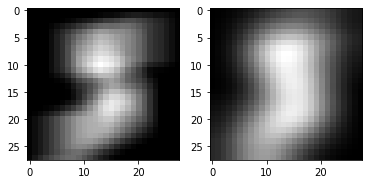

In [0]:
# Gaussian filter examples
example = x_train[0].reshape(28, 28)
sigma = 51.2
g_example = gaussian_filter(example, sigma=sigma, truncate=3.5/sigma)

fig = plt.figure()
plt.gray()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.imshow(example)
ax2.imshow(g_example)
plt.show()

In [0]:
# Gaussian blurring process
sigma = 1.6
tmp_x_train = map(lambda x:gaussian_filter(x.reshape(28, 28),sigma=sigma,truncate=3.5/sigma), x_train)
x_train = np.array(list(tmp_x_train)).astype('float32')

tmp_x_test = map(lambda x:gaussian_filter(x.reshape(28, 28),sigma=sigma,truncate=3.5/sigma), x_test)
x_test = np.array(list(tmp_x_test)).astype('float32')

In [0]:
x_train, x_test = x_train.astype('float32') / 255.0, x_test.astype('float32') / 255.0

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

class MNISTSequence(tf.keras.utils.Sequence):
  def __init__(self, data=None, batch_size=BATCH_SIZE):
    """Initializes the sequence.
    Args:
      data: Tuple of numpy `array` instances, the first representing images and the second labels.
    """
    self.images, self.labels = data
    self.batch_size = batch_size

  def __len__(self):
    return int(tf.math.ceil(len(self.images) / self.batch_size))

  def __getitem__(self, idx):
    batch_x = self.images[idx * self.batch_size: (idx + 1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size: (idx + 1) * self.batch_size]
    return batch_x, batch_y

In [6]:
# CNN
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(10, activation=Activation(tf.nn.softmax))
])
model.summary()
model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 3, 128)         0

In [8]:
# BNN
kl_divergence_function = (lambda q, p, _: tfp.distributions.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                            tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

bnn_model = Sequential([
    tfp.layers.Convolution2DFlipout(32, (3, 3), kernel_divergence_fn=kl_divergence_function,
                                    activation='relu', padding='same', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    tfp.layers.Convolution2DFlipout(64, (3, 3), kernel_divergence_fn=kl_divergence_function,
                                    activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    tfp.layers.Convolution2DFlipout(128, (3, 3), kernel_divergence_fn=kl_divergence_function,
                                    activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    Flatten(),
    tfp.layers.DenseFlipout(128, kernel_divergence_fn=kl_divergence_function, 
                            activation='relu'),
    Dropout(0.25),
    tfp.layers.DenseFlipout(10, kernel_divergence_fn=kl_divergence_function,
                            activation=tf.nn.softmax)
])
bnn_model.summary()
bnn_model.compile(
    loss='categorical_crossentropy', 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy'], experimental_run_tf_function=False)

Instructions for updating:
Please use `layer.add_weight` method instead.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 28, 28, 32)        608       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 14, 14, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 7, 7, 128)         147584    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 128)         0         
_______________________________________________

In [7]:
# CNN training
model.fit(x_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=10,
          validation_split=0.2,
          verbose=1)
model.evaluate(x_test, y_test, verbose=2)

Train on 48000 samples, validate on 12000 samples
Epoch 1/10
48000/48000 [==============================] - 75s 2ms/sample - loss: 0.3006 - accuracy: 0.9042 - val_loss: 0.0636 - val_accuracy: 0.9812
Epoch 2/10
48000/48000 [==============================] - 74s 2ms/sample - loss: 0.0774 - accuracy: 0.9757 - val_loss: 0.0455 - val_accuracy: 0.9861
Epoch 3/10
48000/48000 [==============================] - 73s 2ms/sample - loss: 0.0549 - accuracy: 0.9833 - val_loss: 0.0378 - val_accuracy: 0.9884
Epoch 4/10
48000/48000 [==============================] - 73s 2ms/sample - loss: 0.0434 - accuracy: 0.9864 - val_loss: 0.0391 - val_accuracy: 0.9887
Epoch 5/10
48000/48000 [==============================] - 73s 2ms/sample - loss: 0.0357 - accuracy: 0.9889 - val_loss: 0.0337 - val_accuracy: 0.9908
Epoch 6/10
48000/48000 [==============================] - 73s 2ms/sample - loss: 0.0306 - accuracy: 0.9901 - val_loss: 0.0276 - val_accuracy: 0.9918
Epoch 7/10
48000/48000 [==============================] 

In [25]:
model.predict(fake_test)

array([[0.09538537, 0.14725591, 0.09551211, 0.08864038, 0.06047766,
        0.09283093, 0.07465662, 0.13007934, 0.12034369, 0.09481797],
       [0.07550549, 0.2834276 , 0.05386291, 0.02899018, 0.16760276,
        0.00729708, 0.19053976, 0.00878214, 0.1458117 , 0.03818035],
       [0.02547475, 0.07840335, 0.4133712 , 0.09580441, 0.06798708,
        0.01836258, 0.08938571, 0.01414368, 0.15599814, 0.04106916]],
      dtype=float32)

In [0]:
def plot_heldout_prediction(input_vals, probs, fname, n=10, title=''):
  """Save a PNG plot visualizing posterior uncertainty on heldout data.
  Args:
    input_vals: A `float`-like Numpy `array` of shape
      `[num_heldout] + IMAGE_SHAPE`, containing heldout input images.
    probs: A `float`-like Numpy array of shape `[num_monte_carlo,
      num_heldout, num_classes]` containing Monte Carlo samples of
      class probabilities for each heldout sample.
    fname: Python `str` filename to save the plot to.
    n: Python `int` number of datapoints to vizualize.
    title: Python `str` title for the plot.
  """
  fig = figure.Figure(figsize=(9, 3*n))
  canvas = backend_agg.FigureCanvasAgg(fig)
  for i in range(n):
    ax = fig.add_subplot(n, 3, 3*i + 1)
    ax.imshow(input_vals[i, :].reshape(IMAGE_SHAPE[:-1]), interpolation='None')

    ax = fig.add_subplot(n, 3, 3*i + 2)
    for prob_sample in probs:
      sns.barplot(np.arange(10), prob_sample[i, :], alpha=0.1, ax=ax)
      ax.set_ylim([0, 1])
    ax.set_title('posterior samples')

    ax = fig.add_subplot(n, 3, 3*i + 3)
    sns.barplot(np.arange(10), tf.reduce_mean(probs[:, i, :], axis=0), ax=ax)
    ax.set_ylim([0, 1])
    ax.set_title('predictive probs')
  fig.suptitle(title)
  fig.tight_layout()
  
  canvas.print_figure(fname, format='png')
  print('saved {}'.format(fname))

In [0]:
# fake test samples
gauss = np.random.normal(0.5,0.1,(28,28,1))
gauss = gauss.reshape(28,28,1)
fake_test = x_test[:3]
fake_test[0][:,:,0] = 0
fake_test[1][:,:,0] = 1
fake_test[2] = gauss
fake_test_label = y_test[:3]
fake_test_label = 0

In [24]:
train_seq = MNISTSequence(data=(x_train, y_train))
# heldout_seq = MNISTSequence(data=(x_test, y_test))
heldout_seq = MNISTSequence(data=(fake_test, fake_test_label))  # fake

for epoch in range(EPOCHS):
    epoch_accuracy, epoch_loss = [], []
    for step, (batch_x, batch_y) in enumerate(train_seq):
      batch_loss, batch_accuracy = bnn_model.train_on_batch(batch_x, batch_y)
      epoch_accuracy.append(batch_accuracy)
      epoch_loss.append(batch_loss)

      if step % 100 == 0:
        print('Epoch: {}, Batch index: {}, '
              'Loss: {:.3f}, Accuracy: {:.3f}'.format(
                  epoch, step,
                  tf.reduce_mean(epoch_loss), tf.reduce_mean(epoch_accuracy)))

      if step == 0:
        # Compute log prob of heldout set by averaging draws from the model:
        # p(heldout | train) = int_model p(heldout|model) p(model|train)
        #                   ~= 1/n * sum_{i=1}^n p(heldout | model_i)
        # where model_i is a draw from the posterior p(model|train).
        print(' ... Running monte carlo inference')
        probs = tf.stack([bnn_model.predict(heldout_seq, verbose=1) for _ in range(50)], axis=0)  # num of Monte Carlo
        mean_probs = tf.reduce_mean(probs, axis=0)
        heldout_log_prob = tf.reduce_mean(tf.math.log(mean_probs))
        print(' ... Held-out nats: {:.3f}'.format(heldout_log_prob))

        plot_heldout_prediction(
            heldout_seq.images, probs,
            fname=os.path.join(RESULT_DIR, 'epoch{}_step{}_pred.png'.format(epoch, step)),
            n=3,
            title='mean heldout logprob {:.2f}'.format(heldout_log_prob))

Epoch: 0, Batch index: 0, Loss: 13.643, Accuracy: 0.125
 ... Running monte carlo inference
1/1 [==============================] - 0s 12ms/step
 ... Held-out nats: -2.447
saved /content/drive/My Drive/master_uppsala/p3_computer-assisted_image_analysis_2_project/bnn_result/epoch0_step0_pred.png
Epoch: 0, Batch index: 100, Loss: 12.178, Accuracy: 0.279
Epoch: 0, Batch index: 200, Loss: 11.474, Accuracy: 0.510
Epoch: 0, Batch index: 300, Loss: 11.081, Accuracy: 0.629
Epoch: 0, Batch index: 400, Loss: 10.824, Accuracy: 0.698
Epoch: 1, Batch index: 0, Loss: 9.746, Accuracy: 0.953
 ... Running monte carlo inference
1/1 [==============================] - 0s 12ms/step
 ... Held-out nats: -2.703
saved /content/drive/My Drive/master_uppsala/p3_computer-assisted_image_analysis_2_project/bnn_result/epoch1_step0_pred.png
Epoch: 1, Batch index: 100, Loss: 9.741, Accuracy: 0.931
Epoch: 1, Batch index: 200, Loss: 9.651, Accuracy: 0.937
Epoch: 1, Batch index: 300, Loss: 9.569, Accuracy: 0.941
Epoch: 1, 